# Manolo Ramírez Pintor - A01706155
## Unsafe Furry Content Detector - CNN

This CNN will determine if a digital art furry piece is safe or not safe content, some use cases for this could be using it for filtering content on safe content artist platforms or any other social media platforms.

First, we will access to our data via Google Drive.

In [1]:
# Acceder a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/IA_2/Furry"
!ls

/content/drive/MyDrive/IA_2/Furry
images_ver_2.zip  mi_modelo_01.h5  mi_modelo_06.h5	 mi_modelo_tf.h5
images_ver_3.zip  mi_modelo_05.h5  mi_modelo_estable.h5


Since I want to work with the fastest speed possible, I will copy all the images to the local storage so they can get processed quickly.

In [3]:
# Copiar info a almacenamiento local
!cp -r /content/drive/MyDrive/IA_2/Furry/images_ver_3.zip /content

In [4]:
# Descomprimir todo
%%capture
%cd /content
!unzip images_ver_3.zip

Just because I wanted to try Colab Processing Credits, I check the GPU info with this cell of code. 

**PS: It wasn't worth it at the end.** A "faster" gpu doesn't do much difference when generating new data for training.

In [5]:
# Ver info de la GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jun  3 23:55:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data Augmentation

To make the Data Augmentation part, we will use a ```ImageDataGenerator``` to generate new images and store them to the RAM while we do the training process.






### Transformations applied:

Some of the following transformations applied were taken because of how the data needs to be managed.

* I set a rotation range of 25 because I don't feel like big rotations are going to make the model learn correctly. 

* The shift ranges are minimal in order to avoid the model learning from very stretched images that could add noise. 

* The shear range is moderated so the model can still know how things should look like. 

* The zoom range is minimal too so we don't lose important details of the images.

I think most of these transformations are good but in moderated values, it really depends on the kind of images you want your model to learn from too.

In [6]:
# Importar librerías necesarias
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear el objeto TensorBoard
tb_callback = TensorBoard(log_dir="logs")

# Cambiar Path a almacenamiento local
path = "/content"

# Establecer los directorios de imagenes, train y test
base_dir = 'images'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir, 'test')

# Crear el Datagen para hacer augmentation
train_datagen = ImageDataGenerator(
								rescale = 1./255,
								rotation_range = 25,
								width_shift_range = 0.1,
								height_shift_range = 0.1,
								shear_range = 0.2,
								zoom_range = 0.15,
								horizontal_flip = True)
							
# Crear directorio augmented
!mkdir augmented

Now, with the ```ImageDataGenerator``` created, we will display 5 test images to see if our Data Gen is working properly and adjust some parameters further.

Found 2874 images belonging to 2 classes.


<Figure size 640x480 with 0 Axes>

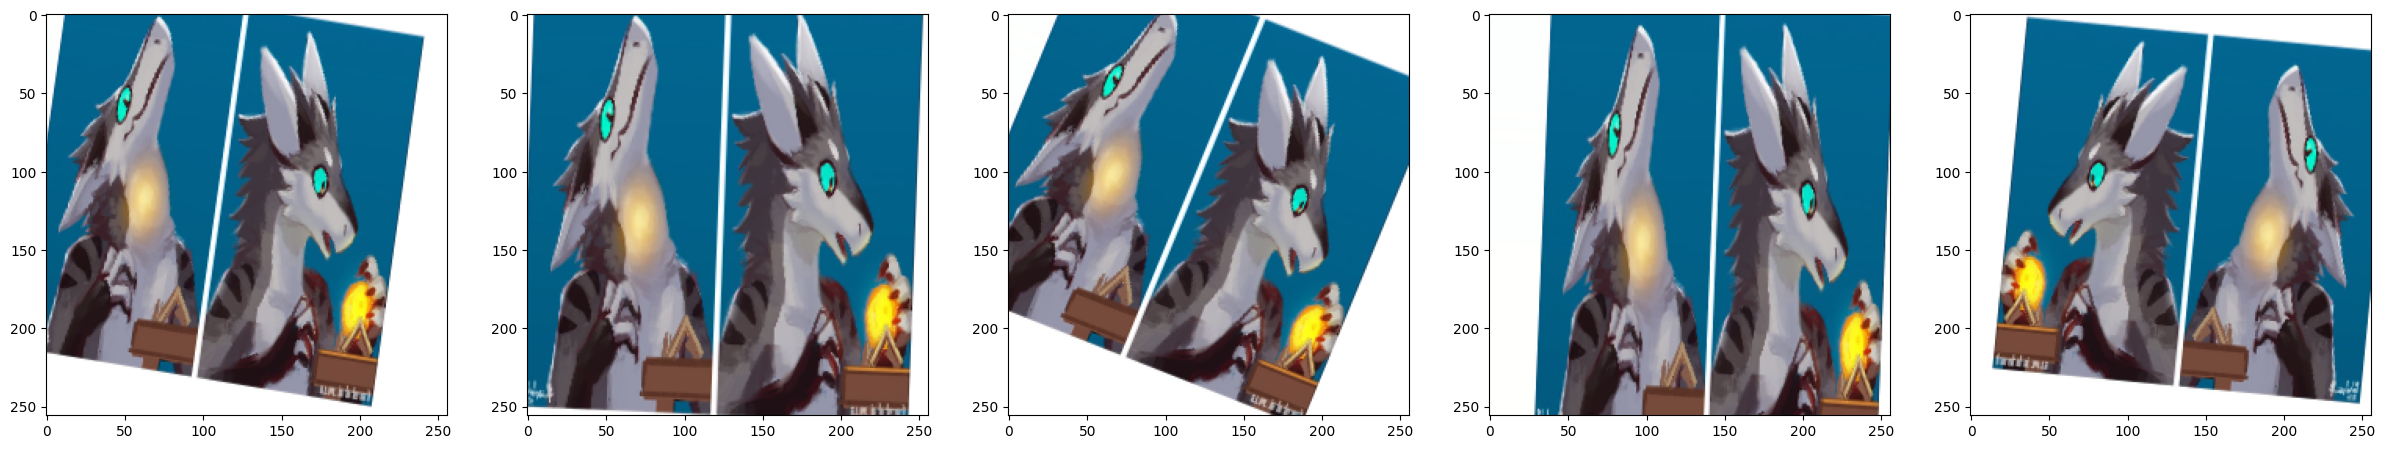

In [ ]:
# Visualizar las imagenes aplicadas con Data Augmentation
train_generator = train_datagen.flow_from_directory(
									train_dir,
									target_size = (256, 256),
									batch_size = 1,
									class_mode ='binary')


plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 5, figsize=(30, 8)) 

for i in range(5) :
  axarr[i].imshow(train_generator[0][0][0])

Now, we will take 8 different images with the imageDataGen applied on them and see how they look.

Aditionally, I applied a blur to censor unsafe images only for the previews, the censorship isn't applied when the model is training.

Found 2874 images belonging to 2 classes.
(8, 150, 150, 3)
[1. 1. 0. 1. 1. 1. 0. 0.]


<Figure size 640x480 with 0 Axes>

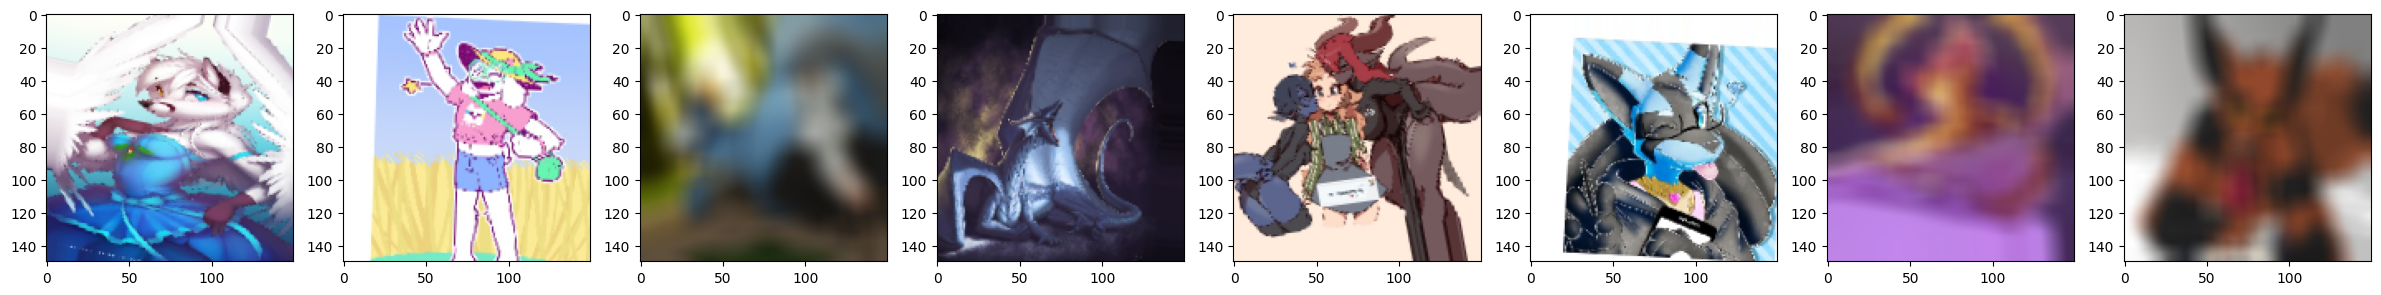

In [7]:
# Censoring library (image processing library)
import cv2

train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (150, 150),
							batch_size = 8,
							class_mode ='binary'
							)


images , labels = train_generator[0]

print(images.shape)
print(labels)

plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4)) 

for i in range(images.shape[0]): 
	if labels[i] == 0:
		# Show the nsfw images with blur applied, kernelSize 15,15
		blurred_image = cv2.blur(images[i], ksize=(15, 15))
		axarr[i].imshow(blurred_image)
	else:
		axarr[i].imshow(images[i])

We prepare the generator for the training process and aditionally, we apply some settings to save the augmented images on a folder on jpg format (to save some space) to see what did the model trained with.

In [8]:
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (256, 256),
							batch_size = 16,
							class_mode ='binary',
							save_to_dir= path + '/augmented', # Colab local storage
              save_prefix='aug',
              save_format='jpg' # Save disk space
							)

Found 2874 images belonging to 2 classes.


# Convolutional Neural Network Model:

**Disclaimer:** During the project, I made 8 different models that had different results but I will be showing the 3 best ones I got and how they did perform after the VGG16 explanation.

We will a convolutional neural network based on how the [VGG16 model](https://datagen.tech/guides/computer-vision/vgg16/) works and how it was made to take advantage of having a base and modify it depending on what we see while training.

Based on [VGG16](https://datagen.tech/guides/computer-vision/vgg16/), I took a high resolution input like they did and added convolutional filters using using (3,3) kernel sizes and ReLu activations because that function only gives us positive numbers and if there's any negatives we just get zero, so that's good for our model training process.

With the usage of Pooling layers, we reduce the number of parameters created by the convolutional steps.

Finally, we get our output doing a dense of only 1 parameter using a sigmoid function to get 0 to 1 values.


## **Things to consider after continuing reading:**
* I did 3 versions of the zips to remove images that could cause noise and also I moved some suggestive images to the NSFW side so it could be more "friendly" about being SFW.

* I changed constantly the number of image batches for the data generator from 8 to 16, 32 and 64. Those changes had an impact on how fast it trained but also on the level of noise it generated, being more noisy with 8 or less and less noisy but not so accurate with values to up to 64. I decided that the batch size could be 16 as a base with the changed I observed during many trial and error cases.

* For the optimizer, after trial and error, I saw Adam performed better when making dynamic changes to the learning rate

* For the learning rate, I found out that for this case, values between 2e-4 and 4e-4 were working good. I sticked with the 2e-4 value at the end.

## **Custom CNN Model** (first model):

For this model, I had a version 1 of the image dataset which contained raw sfw and nsfw data downloads with a bit of human review. ```images_v1.zip``` *(currently deleted, my GDrive storage is almost full)* 

The main problem was the data: "sfw" suggestive images were affecting the model's learning.

Another problem is that this model was too simple for the complexity of the data shown in the images, like lots of art styles, colors, species and more characteristics the furry art has in general.

*Retrained with the v3 version of the images zip to check differences.

Testing with outside the dataset images, the model is able to detect some nsfw characteristics of images but it fails at detecting very obvious things that cover almost half of the image and tiny things that are part of a few pixels in size.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 516128)            0         
                                                                 
 dense (Dense)               (None, 1)                 516129    
                                                                 
Total params: 517,025
Trainable params: 517,025
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
180/180 [==============================] - 184s 966ms/step - loss: 0.7853 - acc: 0.5522
Epoch 2/20
180/18

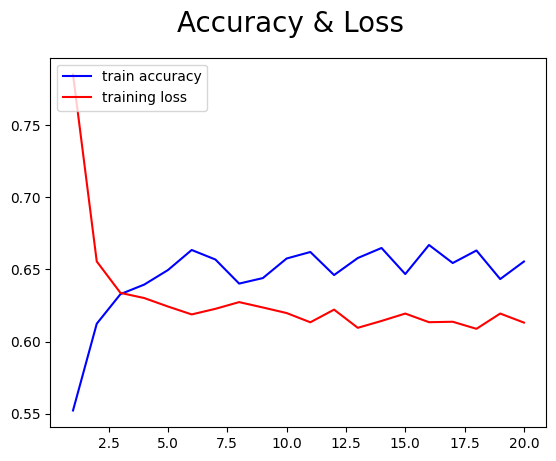

In [9]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
 
CNN1 = models.Sequential()
CNN1.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape = (256,256, 3)))
CNN1.add(layers.MaxPooling2D((2, 2)))
CNN1.add(layers.Flatten())
CNN1.add(layers.Dense(1, activation="sigmoid"))

CNN1.summary()

CNN1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4), loss="binary_crossentropy", metrics=["acc"])

history1 = CNN1.fit(
						train_generator, 
						epochs = 20)

acc = history1.history['acc']
loss = history1.history['loss']

epochs = range(1, len(acc)+1)

fig = plt.figure()
fig.suptitle('Accuracy & Loss', fontsize=20)
plt.plot(epochs,acc,'b',label='train accuracy')
plt.plot(epochs,loss, 'r', label ='training loss')
plt.legend(loc="upper left")
plt.show()

In [10]:
from tensorflow.math import confusion_matrix
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

test_datagen = ImageDataGenerator(1./255)
test_generator = test_datagen.flow_from_directory(
					test_dir,
					target_size = (256, 256),
					batch_size = 20,
					class_mode= 'binary')

test_imgs = test_generator[0][0]
test_labels = test_generator[0][1]

print(test_labels)

predictions = CNN1.predict(test_imgs)
classes_x = predictions.T
classes_x = np.rint(classes_x)

print(classes_x)

Found 220 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 238ms/step
[[1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1.]]


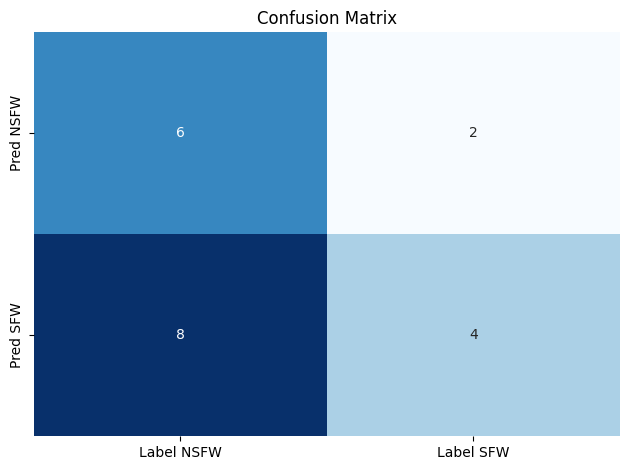

In [11]:
mat = confusion_matrix(classes_x[0], test_labels)

df = pd.DataFrame(mat, index=['Pred NSFW', 'Pred SFW'], 
                              columns=['Label NSFW',  'Label SFW'])

sns.heatmap(df, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.show()

## **CNN Model with more layers** (second model):
This second model was able to detect better big and some small characteristics of nsfw images, now, there's a difficulty with detecting explicit parts that are the same color as the character's fur. 

This tends to usually fail with dark environment images and when there is lack of detail or too much detail.

For example, when there's a simple drawing of a sfw and nsfw character, the model gets confused and doesn't do a well prediction. Same happens with super realistic drawings that show too much detail and the model gets confused too. 

This was initially trained with the zip ```images_ver2.zip``` file located in the Google Drive folder.*

*Retrained with the v3 zip of the images to check differences.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)       

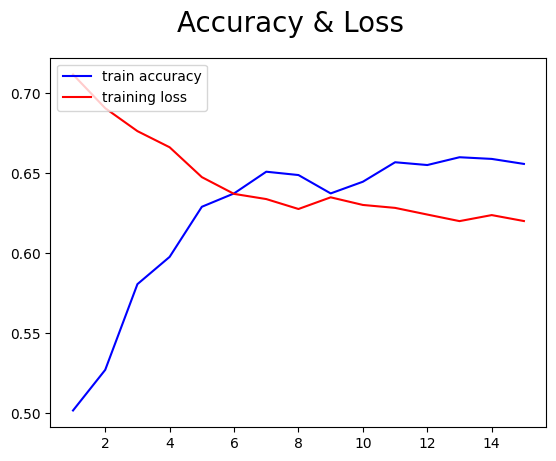

In [12]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers

CNN2 = models.Sequential()
CNN2.add(layers.Conv2D(16, (3, 3), activation="relu", input_shape = (256,256, 3)))
CNN2.add(layers.MaxPooling2D((2, 2)))
CNN2.add(layers.Dropout(0.3))
CNN2.add(layers.Conv2D(32, (3, 3), activation='relu'))
CNN2.add(layers.MaxPooling2D((2, 2)))
CNN2.add(layers.Dropout(0.3))
CNN2.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN2.add(layers.MaxPooling2D((2, 2)))
CNN2.add(layers.Flatten())
CNN2.add(layers.Dense(64, activation='relu'))
CNN2.add(layers.Dropout(0.3))
CNN2.add(layers.Dense(1, activation="sigmoid"))

CNN2.summary()

CNN2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4), loss="binary_crossentropy", metrics=["acc"])

history2 = CNN2.fit(
						train_generator, 
						epochs = 15,
						callbacks=[tb_callback])

acc = history2.history['acc']
loss = history2.history['loss']

epochs = range(1, len(acc)+1)

fig = plt.figure()
fig.suptitle('Accuracy & Loss', fontsize=20)
plt.plot(epochs,acc,'b',label='train accuracy')
plt.plot(epochs,loss, 'r', label ='training loss')
plt.legend(loc="upper left")
plt.show()

In [13]:
print(test_labels)

predictions = CNN2.predict(test_imgs)
classes_x = predictions.T
classes_x = np.rint(classes_x)

print(classes_x)

[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 338ms/step
[[1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1.]]


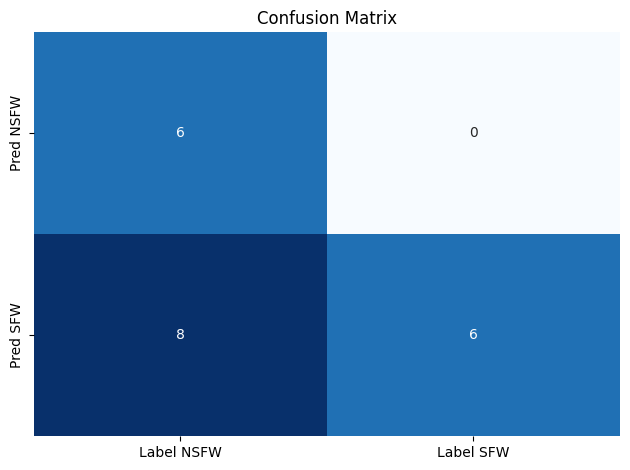

In [14]:
mat = confusion_matrix(classes_x[0], test_labels)

df = pd.DataFrame(mat, index=['Pred NSFW', 'Pred SFW'], 
                              columns=['Label NSFW',  'Label SFW'])

sns.heatmap(df, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.show()

## **VGG16 model** (third model):

Before I started making this model, I generated a new version of the image dataset that had a better classifications of the possible suggestive images to cound them as NSFW to try make the model perform even better. ```images_v3.zip```


This model performed better than the other ones on detecting more particular explicit characteristics of the furry characters with more accuracy and situations that may put the characters into a nsfw situation, like beds and dark environments with two or more characters.

When making the final version of this model, I was playing with the non trainable weights by enabling them and changing things but I didn't find it reliable. So I started playing with the number of neurons that the dense layers had since VGG16 is not that easy to modify and mess up by accident.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 32768)             0         
                                                                 
 dense_15 (Dense)            (None, 32)                1048608   
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 64)                2112      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                

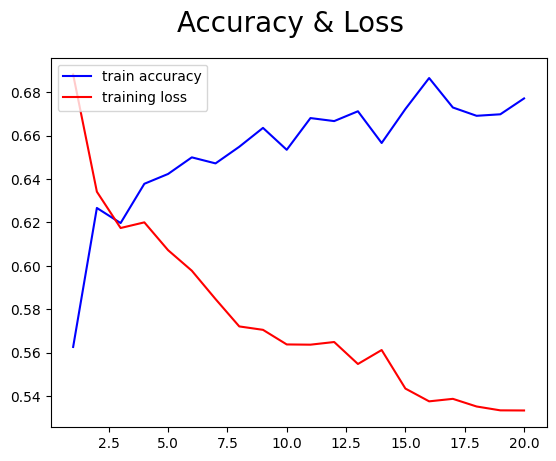

In [19]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers

# Importar VGG16
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
VGG16_model = VGG16(weights="imagenet", include_top=False, input_shape=(256,256,3))
VGG16_model.trainable = False ## Not trainable weights

modelWith_VGG16 = models.Sequential()
modelWith_VGG16.add(VGG16_model)
modelWith_VGG16.add(layers.Flatten())
modelWith_VGG16.add(layers.Dense(32,activation='relu')) 
modelWith_VGG16.add(layers.Dropout(0.35))
modelWith_VGG16.add(layers.Dense(64,activation='relu')) 
modelWith_VGG16.add(layers.Dropout(0.35))
modelWith_VGG16.add(layers.Dense(1,activation='sigmoid'))

modelWith_VGG16.summary()

modelWith_VGG16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4), 
              loss="binary_crossentropy", 
							metrics=["acc"])

history3 = modelWith_VGG16.fit(
						train_generator, 
						epochs = 20,
						callbacks=[tb_callback])

acc = history3.history['acc']
loss = history3.history['loss']

epochs = range(1, len(acc)+1)

fig = plt.figure()
fig.suptitle('Accuracy & Loss', fontsize=20)
plt.plot(epochs,acc,'b',label='train accuracy')
plt.plot(epochs,loss, 'r', label ='training loss')
plt.legend(loc="upper left")
plt.show()

In [48]:
print(test_labels)

predictions = modelWith_VGG16.predict(test_imgs)
classes_x = predictions.T
classes_x = np.rint(classes_x)

print(classes_x)

[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 42ms/step
[[1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1.]]


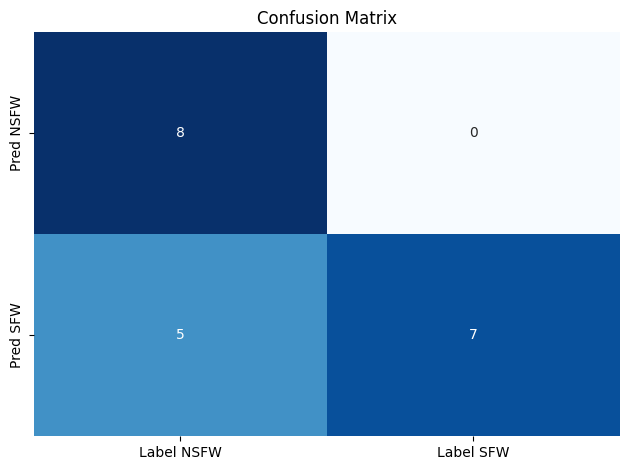

In [66]:
mat = confusion_matrix(classes_x[0], test_labels)

df = pd.DataFrame(mat, index=['Pred NSFW', 'Pred SFW'], 
                              columns=['Label NSFW',  'Label SFW'])

sns.heatmap(df, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.show()

In [67]:
# Save models to Google Drive
CNN1.save('mi_modelo_CNN1.h5') # Save as HDF5
!cp mi_modelo_CNN1.h5 /content/drive/MyDrive/IA_2/Furry # Copy to GDrive

CNN2.save('mi_modelo_CNN2.h5') # Save as HDF5
!cp mi_modelo_CNN2.h5 /content/drive/MyDrive/IA_2/Furry # Copy to GDrive

modelWith_VGG16.save('mi_modelo_con_VGG16.h5') # Save as HDF5
!cp mi_modelo_con_VGG16.h5 /content/drive/MyDrive/IA_2/Furry # Copy to GDrive

## Model Evaluations

Now, that we have all of our models re-trained with the final version of the images, we will evaluate the models.

In [68]:
# Evaluating the different models
test_loss, test_acc = CNN1.evaluate(test_generator, steps = 25)
print('\nCNN1 test acc :\n', test_acc)

test_loss, test_acc = CNN2.evaluate(test_generator, steps = 25)
print('\nCNN2 test acc :\n', test_acc)

test_loss, test_acc = modelWith_VGG16.evaluate(test_generator, steps = 25)
print('\nCNN_with_VGG16 test acc :\n', test_acc)

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


11/25 [============>.................] - ETA: 14s - loss: 59.4739 - acc: 0.5627

25/25 [==============================] - 11s 425ms/step - loss: 59.4739 - acc: 0.5627

CNN1 test acc :
 0.5627272748947144
11/25 [============>.................] - ETA: 14s - loss: 37.4737 - acc: 0.6700

25/25 [==============================] - 11s 437ms/step - loss: 37.4737 - acc: 0.6700

CNN2 test acc :
 0.6700000238418579
11/25 [============>.................] - ETA: 15s - loss: 26.5919 - acc: 0.6964

25/25 [==============================] - 13s 468ms/step - loss: 26.5919 - acc: 0.6964

CNN_with_VGG16 test acc :
 0.6963636255264282


## Conclusions and future work
Surprisingly, the VGG16 base model training performed better at detecting more characteristics of the images that can make predictions to define if is SFW or NSFW.

Sadly, all of the test folder results are always below our training accuracy.

I did manual checks with each model with the section that is below this part to check what did actually change. Here's what changed:

**Model 1:** It predicted many NSFW images as SFW because the first version of the images was confusing the model with suggestive images.

**Model 2:** It got better at predicting NSFW images but it wasn't able to detect some characteristics.

**Model 3:** It got better at predicting if the images are NSFW by detecting more particular characteristics such as bigger and smaller things and a specific type of liquid.

I was thinking at first the model was only overfitting but there was more...

* As I explained before, all of the models were not learning well becuase of problems with similar colors between the important parts that we need to detect, the complexity and simplicity of many images that we have and more.

* To get a better accuracy, we could continue modifying our dataset and model, adding more images and making better clasifications. 

* The other thing we can do it make a main model that can detect the complexity of the image, then, two separate models that train on complex images and simple images in order to detect if there's a sfw or nsfw image present.

* For the problem with similar color on the parts we want to detect, it could be possible to solve it by training on grayscale values and making the model learn specifically from the shapes of the drawings to detect if there is something sfw or nsfw.

So, this is what I learned about making an image classifier for the dark side of the furry fandom. 

**I really want to give a big thanks to my proffesor in guiding me on how to make my model perform better. He was always there to help. 😊**

To all the GitHub watchers, **thank you for following my project!** 

I have a question for you too...

What are you doing here? Can you guys email me at manoloramirezpintor@gmail.com ?

Alright. That's all. Bye! 👋

## Testing the model in an interactive way

In [69]:
# Librerías necesarias
from keras.preprocessing import image 
from keras.utils import load_img
from keras.utils import img_to_array
from keras import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import cv2

# Creamos el directorio para subir nuestras imágenes
!mkdir images2

# Cargamos el modelo a memoria
model = models.load_model("./mi_modelo_con_VGG16.h5")

### Remove the comment "#" on the image you want to test.

The result comes before the image is rendered. All images are censored with a blur effect, no matter if it's SFW or NSFW.

1/1 [==============================] - 0s 35ms/step
[[0.44915706]]
class  0 confindence
NSFW


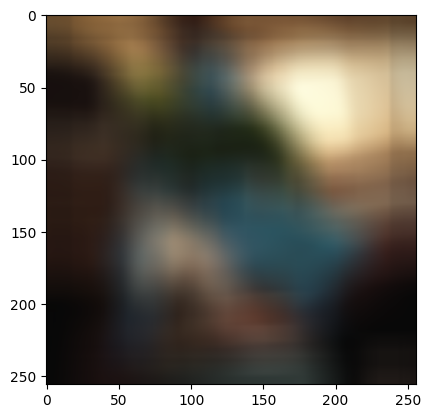

In [80]:
# Descomenta la imagen que quieres usar:

#test_img = './images2/fox_12_sleeping.jpg'
#test_img = './images2/fox_3.jpg'
#test_img = './images2/fox_4.jpg'
#test_img = './images2/fox_7_couch.jpg'
#test_img = './images2/fox_9_clothes.jpg'
#test_img = './images2/tiger_shark_1.jpg'
#test_img = './images2/vrc_fursona.jpg'
#test_img = './images2/nsfw_1.jpg'
#test_img = './images2/nsfw_2.jpg'
#test_img = './images2/nsfw_3.jpg'
#test_img = './images2/nsfw_4.jpg'
test_img = './images2/nsfw_5.jpg'
#test_img = './images2/nsfw_6.jpg'
#test_img = './images2/nsfw_7.jpg'
#test_img = './images2/nsfw_8.jpg'
#test_img = './images2/nsfw_9.jpg'
#test_img = './images2/nsfw_10.jpg'
#test_img = './images2/nsfw_11.jpg'
#test_img = './images2/nsfw_12.jpg'
#test_img = './images2/nsfw_13.jpg'

img_path = test_img 

# Preprocessing
img = load_img(img_path,  target_size=(256,256))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

# Response from the model
confidence = model.predict(img_tensor)
predict_class = (confidence > 0.5).astype("int32")
print (confidence)
print ("class ", predict_class[0][0], "confindence", )

isnsfw = False

# Prediction
if predict_class[0][0] == 0:
  print("NSFW")
  isnsfw = True
else:
  print("SFW")

# Plot the image to predict
blurred_image = cv2.blur(img_tensor[0], ksize=(35, 35)) # Censor with ksize=35
plt.imshow(blurred_image)
plt.show()